# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
np.random.seed(0) # same results every time

In [3]:
# load distance matrix
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [4]:
### Multi-dimensional scaling
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.5254718341134315, pvalue=1.4469404246620797e-170)

In [5]:
# load original 1854*49 embeddings (1854 concepts represented by 49 features)
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [6]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [7]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [8]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [9]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 16)

In [10]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,0.002590,-0.102763,0.261239,0.156872,-0.064567,0.004923,-0.195545,0.779739,1,animal
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,0.351592,0.134520,0.458594,0.048972,-0.101030,0.023103,-0.337668,0.798485,13,home decor
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,-0.029730,0.344954,0.359867,-0.004934,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument
4,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,-0.051208,-0.094109,0.443687,0.401814,0.091931,-0.346259,-0.305948,0.794466,9,electronic device
5,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,-0.213374,-0.119390,0.202198,0.172749,0.163807,-0.073321,-0.366310,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,0.126607,0.031242,0.100010,-0.720695,0.063923,0.005449,-0.067915,0.803129,24,toy
1848,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,0.237343,-0.130576,0.331342,-0.341870,0.345617,-0.052571,-0.162395,0.765881,10,food
1850,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,0.322599,-0.164938,0.340931,-0.381657,0.315573,-0.075001,-0.298887,0.843158,10,food
1851,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,-0.002190,-0.115715,0.230700,0.325621,-0.136880,0.001311,-0.159804,0.800163,1,animal


### Cartesian

In [11]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,0.002590,-0.102763,0.261239,0.156872,-0.064567,0.004923,-0.195545
1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,0.351592,0.134520,0.458594,0.048972,-0.101030,0.023103,-0.337668
2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,-0.029730,0.344954,0.359867,-0.004934,-0.258238,-0.195335,-0.489841
3,-0.253700,-0.144712,0.092875,-0.197541,-0.147820,-0.085465,0.493489,-0.394751,-0.097714,0.289042,-0.027099,0.614921,-0.259616,0.073372,0.203924,-0.387516
4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,-0.051208,-0.094109,0.443687,0.401814,0.091931,-0.346259,-0.305948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.254174,-0.147885,-0.049687,-0.214618,0.145857,-0.548353,0.281969,-0.353209,0.008595,0.433871,0.151372,0.464989,-0.159256,-0.032621,0.248313,-0.587194
1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,0.322599,-0.164938,0.340931,-0.381657,0.315573,-0.075001,-0.298887
1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,-0.002190,-0.115715,0.230700,0.325621,-0.136880,0.001311,-0.159804
1852,-0.288522,0.036183,0.137136,-0.215078,0.242237,-0.553400,0.316395,-0.195523,0.222589,-0.048629,0.009155,0.410221,-0.259770,-0.078617,0.030411,-0.131616


In [12]:
### linreg: cartesian coordinates and z-score memorability
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     38.99
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          1.83e-104
Time:                        18:07:51   Log-Likelihood:                -2359.7
No. Observations:                1854   AIC:                             4753.
Df Residuals:                    1837   BIC:                             4847.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0124      0.098      0.127      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Polar coordinates

In [13]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


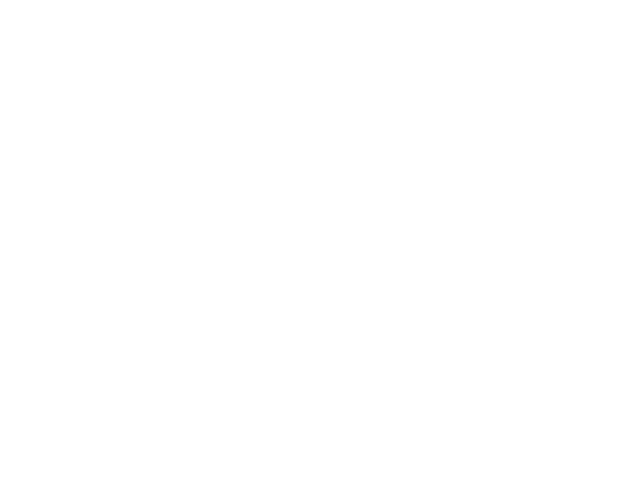

(array([  6.,  11.,  56., 163., 386., 529., 401., 212.,  78.,  12.]),
 array([0.5005291 , 0.59966724, 0.69880538, 0.79794352, 0.89708166,
        0.99621981, 1.09535795, 1.19449609, 1.29363423, 1.39277237,
        1.49191052]),
 <BarContainer object of 10 artists>)

In [14]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [15]:
### Radius vs. memorability
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     16.09
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.29e-05
Time:                        18:07:51   Log-Likelihood:                -2622.7
No. Observations:                1854   AIC:                             5249.
Df Residuals:                    1852   BIC:                             5260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.6516      0.162     -4.011      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### KMeans: clustering concepts as we did in hyperbolic space

In [16]:
## import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1454.4357985731538, 1245.915734277853, 1119.2174127317508, 1032.6025719089994, 963.3804155501399, 908.4103173126045, 859.7863583897653, 814.6271701476009, 784.902742740771, 757.2428804880187, 738.1654285940684, 715.7905202392972, 702.4354917668245, 690.0893933487552]


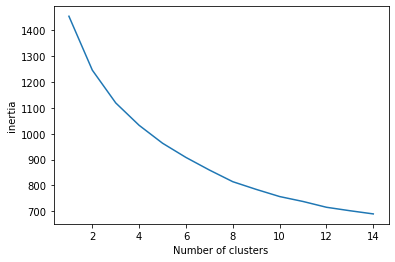

In [17]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [18]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-0.28153743, -0.00408928, -0.08422042, -0.23298554,  0.18488439,
        -0.31094138,  0.12575603, -0.22608423,  0.15091114,  0.21320032,
         0.16290267,  0.3812259 , -0.10901196, -0.07089123, -0.13561039,
        -0.35802507],
       [-0.26173707, -0.11474077, -0.0310135 , -0.15398977,  0.15725979,
        -0.08853179,  0.3037775 , -0.15587608,  0.16056949,  0.21848447,
        -0.20536047,  0.27391819, -0.20891776,  0.11546534,  0.05581814,
        -0.29254867],
       [-0.00431119, -0.13947566,  0.27516815,  0.00185629,  0.07853042,
        -0.25316249,  0.21513199,  0.12929626,  0.01641669, -0.32635276,
         0.00786131,  0.21119774, -0.25203983,  0.07688922,  0.11448377,
         0.09345908],
       [-0.37701648, -0.1011152 , -0.01748263, -0.14479129, -0.01936152,
        -0.2920987 , -0.05072804, -0.19929104,  0.02592475, -0.0486283 ,
        -0.16015166,  0.16901269,  0.12707471, -0.1055329 ,  0.0902645 ,
        -0.17964349]])

In [19]:
### cluster 0: cartesian coordinates predict memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     9.430
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           9.70e-21
Time:                        18:07:54   Log-Likelihood:                -693.57
No. Observations:                 537   AIC:                             1421.
Df Residuals:                     520   BIC:                             1494.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9567      0.267      3.587      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
### cluster 0: radius predict memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3777
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.539
Time:                        18:07:54   Log-Likelihood:                -761.78
No. Observations:                 537   AIC:                             1528.
Df Residuals:                     535   BIC:                             1536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1864      0.303     -0.615      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
### cluster 1: cartesian coordinates predict memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     9.579
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           4.31e-21
Time:                        18:07:54   Log-Likelihood:                -689.80
No. Observations:                 535   AIC:                             1414.
Df Residuals:                     518   BIC:                             1486.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0357      0.316      0.113      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
### cluster 1: radius predict memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     23.53
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.62e-06
Time:                        18:07:54   Log-Likelihood:                -747.58
No. Observations:                 535   AIC:                             1499.
Df Residuals:                     533   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.7728      0.365     -4.851      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
### cluster 2: cartesian coordinates predict memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     10.37
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           7.93e-21
Time:                        18:07:54   Log-Likelihood:                -373.08
No. Observations:                 312   AIC:                             780.2
Df Residuals:                     295   BIC:                             843.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0975      0.305      3.598      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
### cluster 2: radius predict memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     32.32
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.02e-08
Time:                        18:07:54   Log-Likelihood:                -427.24
No. Observations:                 312   AIC:                             858.5
Df Residuals:                     310   BIC:                             866.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.1152      0.372      5.685      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### cluster 3: cartesian coordinates predict memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.824
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.84e-09
Time:                        18:07:54   Log-Likelihood:                -629.93
No. Observations:                 470   AIC:                             1294.
Df Residuals:                     453   BIC:                             1364.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1082      0.246     -0.440      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
### cluster 3: radius predict memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7704
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.381
Time:                        18:07:54   Log-Likelihood:                -666.51
No. Observations:                 470   AIC:                             1337.
Df Residuals:                     468   BIC:                             1345.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3181      0.362     -0.878      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
# variances in mem explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.22852237903485673

In [28]:
# variances in mem explained by radius across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.02871069556179151

### Within-category attraction (correlation distance)

In [29]:
def calculate_typicality(group):
    """
    Calculate within-category attraction of each concept using average correlation distance within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [30]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,-0.102763,0.261239,0.156872,-0.064567,0.004923,-0.195545,0.779739,1,animal,0.810913
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,0.134520,0.458594,0.048972,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0.247628
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,0.344954,0.359867,-0.004934,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0.624589
4,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,-0.094109,0.443687,0.401814,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0.522380
5,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,-0.119390,0.202198,0.172749,0.163807,-0.073321,-0.366310,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.031242,0.100010,-0.720695,0.063923,0.005449,-0.067915,0.803129,24,toy,0.246697
1848,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,-0.130576,0.331342,-0.341870,0.345617,-0.052571,-0.162395,0.765881,10,food,0.786900
1850,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,-0.164938,0.340931,-0.381657,0.315573,-0.075001,-0.298887,0.843158,10,food,0.770485
1851,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,-0.115715,0.230700,0.325621,-0.136880,0.001311,-0.159804,0.800163,1,animal,0.764335


In [31]:
### Cartesian coordinates predict typicality
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     44.97
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          2.57e-112
Time:                        18:07:54   Log-Likelihood:                -1588.3
No. Observations:                1324   AIC:                             3211.
Df Residuals:                    1307   BIC:                             3299.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.6262      0.114    -14.283      0.0

In [32]:
### Radius predict typicality
concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     16.09
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.38e-05
Time:                        18:07:54   Log-Likelihood:                -1870.7
No. Observations:                1324   AIC:                             3745.
Df Residuals:                    1322   BIC:                             3756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.7881      0.196      4.011      0.0

In [33]:
### Cartesian coordinates and typicality predict memorability
zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     32.37
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.05e-87
Time:                        18:07:54   Log-Likelihood:                -1645.9
No. Observations:                1324   AIC:                             3328.
Df Residuals:                    1306   BIC:                             3421.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1323      0.128      1.034      0.3

In [34]:
### Radius and typicality predict memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     28.61
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.89e-13
Time:                        18:07:54   Log-Likelihood:                -1850.6
No. Observations:                1324   AIC:                             3707.
Df Residuals:                    1321   BIC:                             3723.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.7048      0.195     -3.619      0.0

In [35]:
# within-category attraction predict memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           5.50e-11
Time:                        18:07:54   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

##### Cluster level typicality

In [36]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,0.261239,0.156872,-0.064567,0.004923,-0.195545,0.779739,1,animal,3,0.810913
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,0.458594,0.048972,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0,0.247628
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,0.359867,-0.004934,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0,0.624589
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.443687,0.401814,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0,0.522380
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,0.202198,0.172749,0.163807,-0.073321,-0.366310,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.100010,-0.720695,0.063923,0.005449,-0.067915,0.803129,24,toy,1,0.246697
1320,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,0.331342,-0.341870,0.345617,-0.052571,-0.162395,0.765881,10,food,1,0.786900
1321,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.340931,-0.381657,0.315573,-0.075001,-0.298887,0.843158,10,food,1,0.770485
1322,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,0.230700,0.325621,-0.136880,0.001311,-0.159804,0.800163,1,animal,3,0.764335


In [37]:
### cluster 0: cartesian coordinates and typicality predict memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     4.942
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.65e-09
Time:                        18:07:54   Log-Likelihood:                -447.26
No. Observations:                 343   AIC:                             930.5
Df Residuals:                     325   BIC:                             999.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.1740      0.374      3.142      0.0

In [38]:
### cluster 0: cartesian coordinates predict typicality
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     16.55
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.22e-33
Time:                        18:07:54   Log-Likelihood:                -384.71
No. Observations:                 343   AIC:                             803.4
Df Residuals:                     326   BIC:                             868.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3634      0.310     -1.171      0.2

In [39]:
### cluster 0: radius and typicality predict memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.01369
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.986
Time:                        18:07:54   Log-Likelihood:                -486.68
No. Observations:                 343   AIC:                             979.4
Df Residuals:                     340   BIC:                             990.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0310      0.416     -0.075      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
### cluster 1: cartesian coordinates and typicality predict memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     7.924
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.27e-17
Time:                        18:07:54   Log-Likelihood:                -571.83
No. Observations:                 446   AIC:                             1180.
Df Residuals:                     428   BIC:                             1253.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0257      0.381     -0.068      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### cluster 1: cartesian coordinates predict typicality
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     27.15
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.82e-55
Time:                        18:07:54   Log-Likelihood:                -476.89
No. Observations:                 446   AIC:                             987.8
Df Residuals:                     429   BIC:                             1057.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0592      0.308     -0.193      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
### cluster 1: radius and typicality predict memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     15.62
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.79e-07
Time:                        18:07:54   Log-Likelihood:                -617.65
No. Observations:                 446   AIC:                             1241.
Df Residuals:                     443   BIC:                             1254.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.5698      0.402     -3.905      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
### cluster 2: cartesian coordinates predict memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     7.400
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.31e-14
Time:                        18:07:54   Log-Likelihood:                -251.99
No. Observations:                 215   AIC:                             540.0
Df Residuals:                     197   BIC:                             600.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0347      0.420      2.466      0.0

In [44]:
### cluster 2: cartesian coordinates predict typicality
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     16.04
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           8.50e-28
Time:                        18:07:54   Log-Likelihood:                -215.70
No. Observations:                 215   AIC:                             465.4
Df Residuals:                     198   BIC:                             522.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2406      0.353      0.681      0.4

In [45]:
### cluster 2: radius and typicality predict memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     17.24
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.16e-07
Time:                        18:07:54   Log-Likelihood:                -288.87
No. Observations:                 215   AIC:                             583.7
Df Residuals:                     212   BIC:                             593.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.0488      0.551      3.716      0.0

In [46]:
### cluster 3: cartesian coordinates predict memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     8.120
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           7.43e-17
Time:                        18:07:54   Log-Likelihood:                -393.83
No. Observations:                 320   AIC:                             823.7
Df Residuals:                     302   BIC:                             891.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1950      0.322      0.605      0.5

In [47]:
### cluster 3: cartesian coordinates predict typicality
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     45.85
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           4.69e-71
Time:                        18:07:54   Log-Likelihood:                -257.27
No. Observations:                 320   AIC:                             548.5
Df Residuals:                     303   BIC:                             612.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0490      0.201     -5.217      0.0

In [48]:
### cluster 3: radius and typicality predict memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     19.95
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.90e-09
Time:                        18:07:54   Log-Likelihood:                -435.09
No. Observations:                 320   AIC:                             876.2
Df Residuals:                     317   BIC:                             887.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.2127      0.444     -2.733      0.0

Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [49]:
# variances in mem explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.2729590240705033

In [50]:
# variances in within-category attraction explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2) + sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

-0.2330238970792491

In [51]:
# variances in mem explained by radius across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.07194807730076502

In [52]:
### Cluster and typicality predict memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     35.32
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.14e-15
Time:                        18:07:54   Log-Likelihood:                -1844.2
No. Observations:                1324   AIC:                             3694.
Df Residuals:                    1321   BIC:                             3710.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1231      0.024      5.109      0.0

### Category cohesiveness

In [53]:
def category_cohesive(df, cat_col):
    """
    Test cohesiveness of all categories: avg distance within category / avg distance with all other categories
    """
    coord_col = np.arange(0, 16)
    within_distance = []
    between_distance = []
    centroids = df.groupby('bigcat')[coord_col].apply(np.mean).reset_index()

    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        wtn_distance = []
        for idx in range(len(category)):
            concept = category.iloc[idx]
            other_concepts = category[category['index'] != concept['index']]
            wtn_distance.append((np.sqrt(((other_concepts[coord_col] - concept[coord_col])**2).sum(1))).mean(0))
        within_distance.append(np.mean(wtn_distance))
        cat_centroid = np.array(centroids[centroids['bigcat'] == cat][coord_col])
        other_centroids = np.array(centroids[centroids['bigcat'] != cat][coord_col])
        btw_distance = (np.sqrt(((other_centroids - cat_centroid)**2).sum(1))).mean(0)
        between_distance.append(btw_distance)
    
    return np.array(within_distance) / np.array(between_distance)

cohesiveness = category_cohesive(mean_concept_in_feat_cat_na, 'bigcat')
pd.DataFrame(cohesiveness).to_csv('../outputs/category_cohesiveness_16deu.csv')


In [54]:
cohesiveness

array([0.65094635, 1.46149682, 0.7996761 , 1.07227238, 1.1958815 ,
       1.16208827, 1.1788209 , 0.82076462, 0.82691576, 0.85761657,
       0.62505786, 0.77117571, 1.53785241, 0.96621341, 0.84748261,
       1.28720916, 1.37550864, 1.25631703, 0.62374599, 1.27073258,
       1.29843213, 0.99086393, 0.73978838])

### Within-category attraction (correlation distance) calculated by cluster (results not reported)

In [55]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,0.261239,0.156872,-0.064567,0.004923,-0.195545,0.779739,1,animal,3,0.439865
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,0.458594,0.048972,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0,0.297801
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,0.359867,-0.004934,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0,0.284763
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.443687,0.401814,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0,0.231661
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,0.202198,0.172749,0.163807,-0.073321,-0.366310,0.806000,12,furniture,3,0.057168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.100010,-0.720695,0.063923,0.005449,-0.067915,0.803129,24,toy,1,0.008491
1320,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,0.331342,-0.341870,0.345617,-0.052571,-0.162395,0.765881,10,food,1,0.551108
1321,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.340931,-0.381657,0.315573,-0.075001,-0.298887,0.843158,10,food,1,0.524696
1322,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,0.230700,0.325621,-0.136880,0.001311,-0.159804,0.800163,1,animal,3,0.414291


In [56]:
### overall cartesian coordinates and typicality predict memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     33.03
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           4.48e-89
Time:                        18:07:57   Log-Likelihood:                -1641.9
No. Observations:                1324   AIC:                             3320.
Df Residuals:                    1306   BIC:                             3413.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2168      0.131      1.658      0.0

In [57]:
### overall cartesian predict within-category attraction (correlation distance)
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     90.73
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          1.14e-198
Time:                        18:07:57   Log-Likelihood:                -1384.1
No. Observations:                1324   AIC:                             2802.
Df Residuals:                    1307   BIC:                             2890.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6392      0.098    -16.798      0.0

In [58]:
### overall radius and typicality predict memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     67.94
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           8.22e-29
Time:                        18:07:57   Log-Likelihood:                -1813.9
No. Observations:                1324   AIC:                             3634.
Df Residuals:                    1321   BIC:                             3649.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0411      0.193     -5.390      0.0

In [59]:
### overall radius predict within-category attraction (correlation distance)
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     69.19
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.20e-16
Time:                        18:07:57   Log-Likelihood:                -1844.9
No. Observations:                1324   AIC:                             3694.
Df Residuals:                    1322   BIC:                             3704.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.6027      0.193      8.318      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 0: cartesian coordinates and typicality predict memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.864
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.55e-09
Time:                        18:07:57   Log-Likelihood:                -447.82
No. Observations:                 343   AIC:                             931.6
Df Residuals:                     325   BIC:                             1001.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9384      0.389      2.413      0.0

In [61]:
### cluster 0: radius and typicality predict memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.011
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.365
Time:                        18:07:57   Log-Likelihood:                -485.68
No. Observations:                 343   AIC:                             977.4
Df Residuals:                     340   BIC:                             988.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2819      0.424      0.665      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 1: cartesian coordinates and typicality predict memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     10.18
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           6.50e-23
Time:                        18:07:57   Log-Likelihood:                -557.11
No. Observations:                 446   AIC:                             1150.
Df Residuals:                     428   BIC:                             1224.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6770      0.391      1.732      0.0

In [63]:
### cluster 1: radius and typicality predict memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     57.17
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           8.21e-23
Time:                        18:07:57   Log-Likelihood:                -581.65
No. Observations:                 446   AIC:                             1169.
Df Residuals:                     443   BIC:                             1182.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.4698      0.371     -3.965      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [64]:
### cluster 2: cartesian coordinates and typicality predict memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     7.507
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.87e-14
Time:                        18:07:57   Log-Likelihood:                -251.38
No. Observations:                 215   AIC:                             538.8
Df Residuals:                     197   BIC:                             599.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9142      0.428      2.134      0.0

In [65]:
### cluster 2: radius and typicality predict memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     16.05
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.23e-07
Time:                        18:07:57   Log-Likelihood:                -289.91
No. Observations:                 215   AIC:                             585.8
Df Residuals:                     212   BIC:                             595.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.1076      0.649      3.248      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 3: cartesian coordinates and typicality predict memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     7.990
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.47e-16
Time:                        18:07:57   Log-Likelihood:                -394.64
No. Observations:                 320   AIC:                             825.3
Df Residuals:                     302   BIC:                             893.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1758      0.365      0.482      0.6

In [67]:
### cluster 3: radius and typicality predict memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     23.52
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.00e-10
Time:                        18:07:57   Log-Likelihood:                -431.93
No. Observations:                 320   AIC:                             869.9
Df Residuals:                     317   BIC:                             881.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.5148      0.448     -3.379      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
# variances in mem explained by cartesian coordinates and typicality across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.2883721599816921

In [69]:
# variances in mem explained by radius and typicality across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.12321656147685156

In [70]:
### linreg: radius of original 49d embeddings and z-score memorability
zscore_mem = stats.zscore(cat_concept_mem['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((original_embeddings**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.989
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.159
Time:                        18:07:58   Log-Likelihood:                -2629.7
No. Observations:                1854   AIC:                             5263.
Df Residuals:                    1852   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1544      0.109     -1.410      0.1

In [71]:
# saving cluster labels to file
cluster_label = pd.read_csv('../outputs/cluster_label.csv', index_col=0)
cluster_label

,label
0,3
1,0
2,0
3,0
4,0
...,...
1849,1
1850,2
1851,3
1852,1


In [72]:
concept_coord_cluster['cluster'] = cluster_label
concept_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,cluster
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,0.261239,0.156872,-0.064567,0.004923,-0.195545,0.779739,1,animal,3,3
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,0.458594,0.048972,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0,0
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,0.359867,-0.004934,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0,0
3,3,-0.253700,-0.144712,0.092875,-0.197541,-0.147820,-0.085465,0.493489,-0.394751,-0.097714,...,0.614921,-0.259616,0.073372,0.203924,-0.387516,0.761851,99,NaN,1,0
4,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.443687,0.401814,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,1849,-0.254174,-0.147885,-0.049687,-0.214618,0.145857,-0.548353,0.281969,-0.353209,0.008595,...,0.464989,-0.159256,-0.032621,0.248313,-0.587194,0.722655,99,NaN,0,1
1850,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.340931,-0.381657,0.315573,-0.075001,-0.298887,0.843158,10,food,1,2
1851,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,0.230700,0.325621,-0.136880,0.001311,-0.159804,0.800163,1,animal,3,3
1852,1852,-0.288522,0.036183,0.137136,-0.215078,0.242237,-0.553400,0.316395,-0.195523,0.222589,...,0.410221,-0.259770,-0.078617,0.030411,-0.131616,0.797468,99,NaN,0,1


In [73]:
### cluster 0: radius predict memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['cluster'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     24.79
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           8.12e-07
Time:                        18:07:58   Log-Likelihood:                -941.32
No. Observations:                 672   AIC:                             1887.
Df Residuals:                     670   BIC:                             1896.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.3076      0.263     -4.979      0.0

In [74]:
### cluster 1: radius predict memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['cluster'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2039
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.652
Time:                        18:07:58   Log-Likelihood:                -851.26
No. Observations:                 600   AIC:                             1707.
Df Residuals:                     598   BIC:                             1715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1292      0.286     -0.452      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [75]:
### cluster 2: radius predict memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['cluster'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     28.87
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.31e-07
Time:                        18:07:58   Log-Likelihood:                -566.33
No. Observations:                 409   AIC:                             1137.
Df Residuals:                     407   BIC:                             1145.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.8289      0.340     -5.373      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [76]:
### cluster 3: radius predict memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['cluster'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.226
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.270
Time:                        18:07:58   Log-Likelihood:                -244.86
No. Observations:                 173   AIC:                             493.7
Df Residuals:                     171   BIC:                             500.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8911      0.805     -1.107      0.2

In [77]:
# variances in mem explained by radius across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.028321178058602903

### Semantic clusters

In [78]:
### for each category in the BCC group, compute the avg radius and pick 1-2 examplar concepts with the radius
### provide t-test result for comparison
### bcc: “body part”, “clothing”, and “clothing accessories” 

def compute_cat_r(group):
    return (np.sqrt((group[coord_col]**2).sum(1))).mean(0)

coord_col = np.arange(0, 16)
bcc_group = mean_concept_in_feat_cat[(mean_concept_in_feat_cat['cat_name'] == 'body part') | (mean_concept_in_feat_cat['cat_name'] == 'clothing') | (mean_concept_in_feat_cat['cat_name'] == 'clothing accessory')]
bcc_group['radius'] = np.sqrt((bcc_group[coord_col]**2).sum(1))
bcc_avg_r = (np.sqrt((bcc_group[coord_col]**2).sum(1))).mean(0)
bcc_cat_r = bcc_group.groupby('cat_name').apply(compute_cat_r)
bcc_cat_r


/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_53993/371363037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcc_group['radius'] = np.sqrt((bcc_group[coord_col]**2).sum(1))


cat_name
body part             1.110669
clothing              1.107520
clothing accessory    1.029985
dtype: float64

In [79]:
from scipy.stats import ttest_ind

def pairwise_ttest(df, group_col, ind_var):
    """
    Pairwise t-test for categories in the same semantic group
    """
    group_names = df[group_col].unique()
    grouped = df.groupby(group_col)
    print(grouped[ind_var].count())
    ttest = {}
    
    for g_idx in range(len(group_names)):
        group = grouped.get_group(group_names[g_idx])
        t = {} # add to ttest dict
        for i in range(g_idx, len(group_names), 1):
            t[group_names[i]] = ttest_ind(group[ind_var], grouped.get_group(group_names[i])[ind_var], equal_var=False)
        ttest[group_names[g_idx]] = t
    
    return ttest

# Pairwise t-test among body part, clothing, clothing accessory
pairwise_ttest(bcc_group, 'cat_name', 'radius')

cat_name
body part              34
clothing              109
clothing accessory     15
Name: radius, dtype: int64


{'body part': {'body part': Ttest_indResult(statistic=0.0, pvalue=1.0),
  'clothing': Ttest_indResult(statistic=0.1653186511699275, pvalue=0.869159891566871),
  'clothing accessory': Ttest_indResult(statistic=2.4846462545947205, pvalue=0.02087825972564424)},
 'clothing': {'clothing': Ttest_indResult(statistic=0.0, pvalue=1.0),
  'clothing accessory': Ttest_indResult(statistic=2.522973394048879, pvalue=0.02092263295344889)},
 'clothing accessory': {'clothing accessory': Ttest_indResult(statistic=0.0, pvalue=1.0)}}

In [80]:
### FDD: “food”, “drink”, and “dessert” 

coord_col = np.arange(0, 16)
fdd_group = mean_concept_in_feat_cat[(mean_concept_in_feat_cat['cat_name'] == 'food') | (mean_concept_in_feat_cat['cat_name'] == 'drink') | (mean_concept_in_feat_cat['cat_name'] == 'dessert')]
fdd_group['radius'] = np.sqrt((fdd_group[coord_col]**2).sum(1))
fdd_avg_r = (np.sqrt((fdd_group[coord_col]**2).sum(1))).mean(0)
fdd_cat_r = fdd_group.groupby('cat_name').apply(compute_cat_r)
fdd_cat_r


/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_53993/3451577457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdd_group['radius'] = np.sqrt((fdd_group[coord_col]**2).sum(1))


cat_name
dessert    0.927850
drink      0.916403
food       1.024081
dtype: float64

In [81]:
# Pairwise t-test among food, dessert, drink
pairwise_ttest(fdd_group, 'cat_name', 'radius')


cat_name
dessert     39
drink       18
food       239
Name: radius, dtype: int64


{'food': {'food': Ttest_indResult(statistic=0.0, pvalue=1.0),
  'dessert': Ttest_indResult(statistic=6.766278787792167, pvalue=5.0370439086437626e-09),
  'drink': Ttest_indResult(statistic=5.7843453696516045, pvalue=7.2401147988232026e-06)},
 'dessert': {'dessert': Ttest_indResult(statistic=0.0, pvalue=1.0),
  'drink': Ttest_indResult(statistic=0.5362096664126548, pvalue=0.5952043620971956)},
 'drink': {'drink': Ttest_indResult(statistic=0.0, pvalue=1.0)}}

### Human-rated typicality

In [82]:
# loading human-rated typicality
typ_mapped = typ_coord_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=('_computed', '_rated'))
typ_mapped

,index,0,1,2,3,4,5,6,7,8,...,14,15,cr,bigcat,cat_name,label,typicality_computed,cat,concept,typicality_rated
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,0.004923,-0.195545,0.779739,1,animal,3,0.810913,1,0,4.874352
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,0.023103,-0.337668,0.798485,13,home decor,0,0.247628,13,1,2.613022
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,-0.195335,-0.489841,0.752845,18,musical instrument,0,0.624589,18,2,5.605201
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,-0.346259,-0.305948,0.794466,9,electronic device,0,0.522380,9,4,5.966682
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,-0.073321,-0.366310,0.806000,12,furniture,3,0.509185,12,5,4.451417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,-0.052571,-0.162395,0.765881,10,food,1,0.786900,10,1848,7.064713
1615,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,-0.075001,-0.298887,0.843158,10,food,1,0.770485,10,1850,4.520777
1616,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,0.001311,-0.159804,0.800163,1,animal,3,0.764335,1,1851,7.177455
1617,1853,-0.397366,0.040033,-0.176036,-0.144074,0.381176,-0.221367,0.644963,-0.369888,0.191989,...,0.187902,-0.235526,0.823237,10,food,1,0.705398,10,1853,6.354120


In [83]:
# note that not all concepts have a category --> here we remove those have no category membership
typ_mapped_drop_na = typ_mapped[typ_mapped['bigcat'] == typ_mapped['cat']]
typ_mapped_drop_na['radius'] = np.sqrt((typ_mapped_drop_na.loc[:, 0:15]**2).sum(1))
typ_mapped_drop_na

/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_53993/800831660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  typ_mapped_drop_na['radius'] = np.sqrt((typ_mapped_drop_na.loc[:, 0:15]**2).sum(1))


,index,0,1,2,3,4,5,6,7,8,...,15,cr,bigcat,cat_name,label,typicality_computed,cat,concept,typicality_rated,radius
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,-0.195545,0.779739,1,animal,3,0.810913,1,0,4.874352,1.039172
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,-0.337668,0.798485,13,home decor,0,0.247628,13,1,2.613022,0.984779
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,-0.489841,0.752845,18,musical instrument,0,0.624589,18,2,5.605201,1.126360
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,-0.305948,0.794466,9,electronic device,0,0.522380,9,4,5.966682,0.940568
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,-0.366310,0.806000,12,furniture,3,0.509185,12,5,4.451417,0.746086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,-0.067915,0.803129,24,toy,1,0.246697,24,1847,7.111927,1.014607
1614,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,-0.162395,0.765881,10,food,1,0.786900,10,1848,7.064713,1.006567
1615,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,-0.298887,0.843158,10,food,1,0.770485,10,1850,4.520777,0.993075
1616,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,-0.159804,0.800163,1,animal,3,0.764335,1,1851,7.177455,0.936892


In [84]:
# radius predict human-rated typicality
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03233
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.857
Time:                        18:07:58   Log-Likelihood:                -1833.3
No. Observations:                1292   AIC:                             3671.
Df Residuals:                    1290   BIC:                             3681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0359      0.200     -0.180      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
# human-rated typicality predict memorability
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['typicality_rated']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1171
Date:                Sun, 20 Aug 2023   Prob (F-statistic):              0.732
Time:                        18:07:58   Log-Likelihood:                -1833.2
No. Observations:                1292   AIC:                             3670.
Df Residuals:                    1290   BIC:                             3681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated     0.0070      0.021  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
# radius and human-rated typicality predict memorability
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['radius', 'typicality_rated']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.342
Date:                Sun, 20 Aug 2023   Prob (F-statistic):             0.0132
Time:                        18:07:58   Log-Likelihood:                -1828.9
No. Observations:                1292   AIC:                             3664.
Df Residuals:                    1289   BIC:                             3679.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
radius              -0.5828      0.199  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Between-category repulsion

In [87]:
### compute between-category repulsion by avg/min Euclidean distance from all other categories
from sklearn import preprocessing 

def get_contrast_cat_typ(df, measure, cat_col, by):
    """
    measure = eu (euclidean)
    by = avg (typicality by avg distance) or min (typicality by min distance)
    """
    typ_contrast = {}
    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        for idx in range(len(category)):
            concept = category.iloc[idx]
            typ = 0.0
            if measure == 'eu':
                if by == 'avg':
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).mean(0)
                else: 
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).min(0)
            else:
                tmp = pd.concat([pd.DataFrame(concept).T, others])
                tmp[[0,1,2]] = tmp.loc[:, 0:15].astype(float)
                if by == 'avg':
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0].mean(0)
                else:
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0][1:].min()
            typ_contrast[concept.name] = typ
    df['typ_contrast'] = pd.Series(typ_contrast)
    # rescale typicality
    min_max_scaler = preprocessing.MinMaxScaler()
    df['typ_contrast'] = min_max_scaler.fit_transform(df[['typ_contrast']].values)
    df['typ_contrast'] = 1 - df['typ_contrast']
    
    return df

# between-category repulsion: avg Euclidean distance
typ_tmp = typ_coord_cluster.copy(deep=True)
typ_tmp_avg = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'avg')
typ_tmp_avg['radius'] = np.sqrt((typ_tmp_avg.loc[:, 0:15]**2).sum(1))
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,-0.064567,0.004923,-0.195545,0.779739,1,animal,3,0.810913,0.692890,1.039172
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0,0.247628,0.776498,0.984779
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0,0.624589,0.645569,1.126360
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0,0.522380,0.743955,0.940568
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,0.163807,-0.073321,-0.366310,0.806000,12,furniture,3,0.509185,0.838230,0.746086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.063923,0.005449,-0.067915,0.803129,24,toy,1,0.246697,0.398751,1.014607
1320,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,0.345617,-0.052571,-0.162395,0.765881,10,food,1,0.786900,0.811994,1.006567
1321,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.315573,-0.075001,-0.298887,0.843158,10,food,1,0.770485,0.794559,0.993075
1322,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,-0.136880,0.001311,-0.159804,0.800163,1,animal,3,0.764335,0.662058,0.936892


In [88]:
# radius predict between-category repulsion
zscore_mem = stats.zscore(typ_tmp_avg['typ_contrast'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     185.5
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.25e-39
Time:                        18:08:13   Log-Likelihood:                -1791.7
No. Observations:                1324   AIC:                             3587.
Df Residuals:                    1322   BIC:                             3598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -2.5212      0.185    -13.621      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
# between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     38.30
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           8.10e-10
Time:                        18:08:13   Log-Likelihood:                -1859.8
No. Observations:                1324   AIC:                             3724.
Df Residuals:                    1322   BIC:                             3734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
typ_contrast    -1.1724      0.189     -6.188   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [90]:
# radius and between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     34.24
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           3.18e-15
Time:                        18:08:13   Log-Likelihood:                -1845.2
No. Observations:                1324   AIC:                             3696.
Df Residuals:                    1321   BIC:                             3712.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -1.1157      0.206     -5.419   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,-0.064567,0.004923,-0.195545,0.779739,1,animal,3,0.810913,0.692890,1.039172
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0,0.247628,0.776498,0.984779
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0,0.624589,0.645569,1.126360
3,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0,0.522380,0.743955,0.940568
4,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,0.163807,-0.073321,-0.366310,0.806000,12,furniture,3,0.509185,0.838230,0.746086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.063923,0.005449,-0.067915,0.803129,24,toy,1,0.246697,0.398751,1.014607
1320,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,0.345617,-0.052571,-0.162395,0.765881,10,food,1,0.786900,0.811994,1.006567
1321,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.315573,-0.075001,-0.298887,0.843158,10,food,1,0.770485,0.794559,0.993075
1322,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,-0.136880,0.001311,-0.159804,0.800163,1,animal,3,0.764335,0.662058,0.936892


In [92]:
# For each cluster, print out the linear regression result of cartesian coordinates predicting between-category repulsion (avg Euclidean) 
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['typ_contrast'])
    concept_constant = sm.add_constant(gp.loc[:, 0:15], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     11.89
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.10e-24
Time:                        18:08:13   Log-Likelihood:                -407.88
No. Observations:                 343   AIC:                             849.8
Df Residuals:                     326   BIC:                             915.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.2019      0.332     -3.621      0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.5115649926226673

In [93]:
# For each cluster, print out the linear regression result of between-category repulsion (avg Euclidean) predicting mem
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['cr'])
    concept_constant = sm.add_constant(gp['typ_contrast'], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     13.57
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           0.000268
Time:                        18:08:13   Log-Likelihood:                -480.01
No. Observations:                 343   AIC:                             964.0
Df Residuals:                     341   BIC:                             971.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
typ_contrast    -1.6713      0.454     -3.683 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.030160143215084867

### Within-category attraction (Euclidean distance)

In [94]:
def in_cat_typ(group):
    """
    Compute within-category attraction using Euclidean distance 
        between each concept and all other concepts in the same category
    """
    coef_matrix = np.corrcoef(group.iloc[:, 0:15])
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality_dist'] = typicality
    return group

df_typ = mean_concept_in_feat_cat_na.groupby('bigcat').apply(in_cat_typ)
df_typ = df_typ.groupby('bigcat').apply(calculate_typicality)
df_typ = get_contrast_cat_typ(df_typ, 'eu', 'bigcat', 'avg')
df_typ['radius'] = np.sqrt((df_typ.iloc[:, 0:15]**2).sum(1))
df_typ

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,typicality_dist,typicality,typ_contrast,radius
0,0,-0.684000,-0.102510,-0.001977,-0.161126,-0.083603,-0.545069,-0.156659,-0.315357,-0.040165,...,-0.064567,0.004923,-0.195545,0.779739,1,animal,0.142165,0.810913,0.692890,1.020596
1,1,-0.480093,-0.347490,-0.039716,-0.060931,-0.204651,-0.033460,-0.016872,-0.271556,0.130586,...,-0.101030,0.023103,-0.337668,0.798485,13,home decor,0.718056,0.247628,0.776498,1.362071
2,2,-0.455151,-0.138925,0.128791,-0.228593,0.235532,0.292837,0.052048,-0.359713,0.325356,...,-0.258238,-0.195335,-0.489841,0.752845,18,musical instrument,0.861684,0.624589,0.645569,2.233962
4,4,-0.167391,0.140108,-0.122743,0.134071,0.131831,-0.141127,0.153950,-0.148427,0.359455,...,0.091931,-0.346259,-0.305948,0.794466,9,electronic device,0.967235,0.522380,0.743955,4.083034
5,5,-0.101575,0.136633,0.266680,-0.025094,0.005091,-0.118158,0.229284,-0.245906,0.178835,...,0.163807,-0.073321,-0.366310,0.806000,12,furniture,0.962489,0.509185,0.838230,5.041536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.030734,-0.008827,-0.237062,-0.290984,-0.490401,0.210345,-0.173529,0.076409,0.108204,...,0.063923,0.005449,-0.067915,0.803129,24,toy,0.965513,0.246697,0.398751,1847.000277
1848,1848,-0.428122,-0.105562,-0.064830,-0.265346,0.235544,-0.154280,0.415880,-0.005583,0.207924,...,0.345617,-0.052571,-0.162395,0.765881,10,food,0.995786,0.786900,0.811994,1848.000266
1850,1850,-0.414438,-0.129664,-0.005765,-0.085451,-0.057259,-0.095028,0.366166,-0.171491,0.163650,...,0.315573,-0.075001,-0.298887,0.843158,10,food,0.995786,0.770485,0.794559,1850.000241
1851,1851,-0.617261,-0.077546,0.023510,-0.189678,-0.028388,-0.321632,-0.269389,-0.241300,-0.047352,...,-0.136880,0.001311,-0.159804,0.800163,1,animal,0.989512,0.764335,0.662058,1851.000230


In [95]:
# radius predict within-category attraction (Euclidean distance)
zscore_mem = stats.zscore(df_typ['typicality_dist'])
concept_constant = sm.add_constant(df_typ[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        typicality_dist   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.393
Date:                Sun, 20 Aug 2023   Prob (F-statistic):             0.0657
Time:                        18:08:26   Log-Likelihood:                -1877.0
No. Observations:                1324   AIC:                             3758.
Df Residuals:                    1322   BIC:                             3768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius      9.405e-05   5.11e-05      1.842      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
# within-category attraction (Euclidean distance) predict memorability
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['typicality_dist']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     12.23
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           0.000485
Time:                        18:08:26   Log-Likelihood:                -1872.6
No. Observations:                1324   AIC:                             3749.
Df Residuals:                    1322   BIC:                             3760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
typicality_dist     3.1361      0.897     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [97]:
# radius and within-category attraction (Euclidean distance) predict memorability
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality_dist']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.165
Date:                Sun, 20 Aug 2023   Prob (F-statistic):            0.00216
Time:                        18:08:26   Log-Likelihood:                -1872.5
No. Observations:                1324   AIC:                             3751.
Df Residuals:                    1321   BIC:                             3767.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
radius          -1.656e-05    5.1e-05     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [98]:
# radius, within-category attraction (Euclidean distance), and between-category repulsion (avg Euclidean) predict mem
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality_dist', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     16.49
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.60e-10
Time:                        18:08:26   Log-Likelihood:                -1854.3
No. Observations:                1324   AIC:                             3717.
Df Residuals:                    1320   BIC:                             3737.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
radius          -1.331e-05   5.03e-05     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [99]:
# radius, within-category attraction (correlation distance), and between-category repulsion (avg Euclidean) predict mem
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     34.17
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           2.87e-21
Time:                        18:08:27   Log-Likelihood:                -1829.2
No. Observations:                1324   AIC:                             3666.
Df Residuals:                    1320   BIC:                             3687.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius       -1.405e-07   4.93e-05     -0.003   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


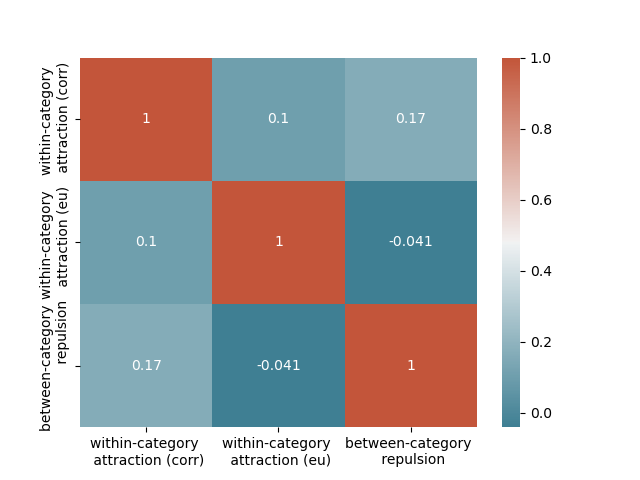

In [100]:
# correlation matrix of within-category attraction (correlation, Euclidean) and between-category repulsion
%matplotlib notebook

corr_matrix = df_typ[['typicality', 'typicality_dist', 'typ_contrast']]
corr_matrix = corr_matrix.rename(columns = {'typicality': 'within-category \n attraction (corr)', 'typicality_dist': 'within-category \n attraction (eu)', 'typ_contrast':'between-category \n repulsion'})
corr_matrix = corr_matrix.corr()
colormap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=colormap)
plt.show()

In [101]:
# Saving concept embeddings, memorability scores, and categories to file
concept_file = mean_concept_in_feat_cat.drop(columns=['index', 'label', 'cluster'], inplace=False)
concept_file.to_csv('../outputs/concept_embeddings_cr_cat_16eu.csv')